In [12]:
import os
import warnings

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pmdarima as pm
import seaborn as sns
from sklearn.cluster import AgglomerativeClustering, ward_tree
from sklearn.metrics import plot_confusion_matrix, accuracy_score, mean_squared_error, precision_score, f1_score, recall_score
from sklearn.naive_bayes import GaussianNB
import yfinance as yf

os.chdir('../')
from src.features.build_features import (
    daily_return, uniform_clustering, create_shifted_rt, downloading_stocks_data, return_in_period, binary_clustering, boxplot_clustering)
from src.models.k2 import k2, graph_from_dict
os.chdir('./notebooks')

RANDOM_SEED = 42

warnings.filterwarnings("ignore")
sns.set_style('whitegrid')
plt.style.use('seaborn-paper')


# Aquisição dos dados

|Country|Index|Ticker|
|---        |---        |---        |
|Brazil|iBovespa|^BVSP|
|USA|Nasdaq Composite|^IXIC|
|USA|NYSE Composite|^NYA|
|USA|Dow Jones|^DJI|
|Argentina|Merval|M.BA|
|Japan|Nikkei 225|^N225|
|China|Shangai Composite|000001.SS|
|China|Hang Seng|^HSI|
|India|BSE 30 Sensex|^BSESN|
|UK|FTSE 100|^FTSE|
|Sweden|Stockholm General|^OMX|
|Germany|Dax|^GDAXI|
|France|Cac 40|^FCHI|

In [13]:
start_date = "2016-01-01"
end_date = "2021-07-31"

ticker = "iBovespa"
# ticker = "NYSE"
# ticker = "Nikkey"

if ticker == "Nikkey":
    df_ticker = yf.download("^N225", start=start_date, end=end_date)
elif ticker == "iBovespa":
    df_ticker = yf.download('^BVSP', start=start_date, end=end_date)
elif ticker == "NYSE":
    df_ticker = yf.download('^NYA', start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


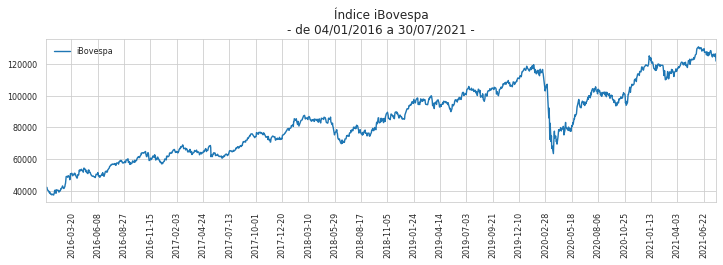

In [14]:
fig = plt.figure(figsize=(12, 3))
ax = fig.add_subplot(111)

ax.plot(df_ticker['Close'], label=ticker)

date_min = df_ticker.index.min()
date_max = df_ticker.index.max()
ax.xaxis.set_major_locator(plt.MaxNLocator(30))
ax.set_xlim(left=date_min, right=date_max)
ax.set_title(f"""Índice {ticker}
- de {date_min.strftime("%d/%m/%Y")} a {date_max.strftime("%d/%m/%Y")} -""", fontsize = 12)

ax.legend(loc='upper left', frameon=False)
plt.xticks(rotation=90)
plt.show();

## Preparação dos dados

Nesta seção, tomaremos as seguintes ações:

1. Separação do conjunto de dados de treinamento (01/01/2011 até 30/04/2021) e de validação do modelo (01/05/2021 até 30/05/2021).
1. Criação do atributo **"p/e"**: $ p/e = 100*(ln({r_{t}}) - ln({r_{t-1}})) $.
1. Criação da resposta **cluster** usando apenas a simples separação. Lembrando que no artigo, os autores compararam duas abordagens diferentes para discretizar a resposta ((a) simples separação e (b) Ward).

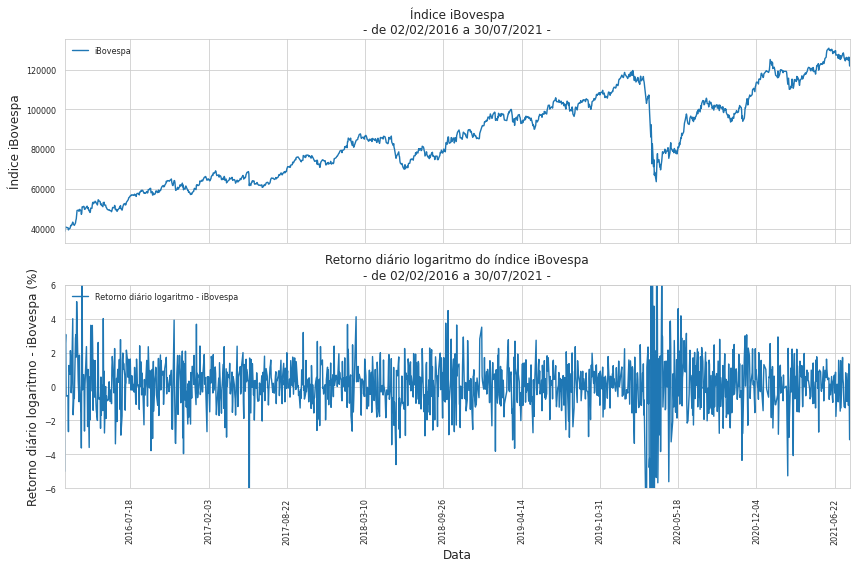

In [15]:
df = df_ticker[["Close"]].copy()
df = daily_return(df)
df = create_shifted_rt(df, np.arange(1, 21, 2))
# df = uniform_clustering(df)
df = binary_clustering(df)
# df = boxplot_clustering(df)
# df = df[[column for column in df.columns if 'cluster_' in column]].copy()
df.dropna(how='any', axis=0, inplace=True)

for column in [column for column in df.columns if 'cluster_' in column]:
    df[column] = df[column].astype(int)

fontsize = 12

fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot(211)

date_min = df.index.min()
date_max = df.index.max()

ax.plot(df_ticker['Close'], label=ticker)

ax.set_ylabel(f'Índice {ticker}', fontsize=fontsize)
ax.set_title(f"""Índice {ticker}
- de {date_min.strftime("%d/%m/%Y")} a {date_max.strftime("%d/%m/%Y")} -""", fontsize = 12)
ax.legend(loc='upper left', frameon=False)

plt.setp(ax.get_xticklabels(), visible=False)

ax = fig.add_subplot(212, sharex=ax)
ax.plot(df['Close'], label=f"Retorno diário logaritmo - {ticker}")
ax.yaxis.set_label("Data")
ax.xaxis.set_major_locator(plt.MaxNLocator(13))
# ax.yaxis.set_major_locator(plt.MaxNLocator(8))
ax.set_ylim(-6, 6)
ax.set_xlim(left=date_min, right=date_max)
ax.set_xlabel('Data', fontsize=fontsize)
ax.set_ylabel(f"Retorno diário logaritmo - {ticker} (%)", fontsize=fontsize)
ax.set_title(f"""Retorno diário logaritmo do índice {ticker}
- de {date_min.strftime("%d/%m/%Y")} a {date_max.strftime("%d/%m/%Y")} -""", fontsize = 12)
ax.legend(loc='upper left', frameon=False)
plt.xticks(rotation=90)

plt.tight_layout()
plt.show();

# ARIMA

Iniciando o ARIMA **sem uma janela deslizante de tempo**.

In [28]:
ntotal = df_ticker.shape[0]
ntest = 20

for cont in np.arange(ntest):
    X_train = df_ticker[:-ntest+cont]
    X_test = df_ticker[-ntest+cont:ntotal-ntest+1+cont]

    X_train["rt"] = (np.log(X_train["Close"]) - np.log(X_train["Close"].shift(periods=1)))*100
    X_test["rt"] = (np.log(X_test["Close"]) - np.log(X_test["Close"].shift(periods=1)))*100
    df_ticker["rt"] = (np.log(df_ticker["Close"]) - np.log(df_ticker["Close"].shift(periods=1)))*100
    X_train = X_train[["Close", "rt"]][1:]

    model = pm.auto_arima(X_train['rt'], erro_action='ignore', trace=False, suppress_warnings=True, maxinter=10, stepwise=False, seasonal=False)

    test_pred, confint = model.predict(n_periods=1, return_conf_int=True)
    resultado[X_test.index[-1]] = {"y_pred": test_pred[0]}

resultado = pd.DataFrame.from_dict(resultado, orient='index')
resultado = pd.concat([resultado, df_ticker[-20:]["rt"]], axis=1)

for column in resultado.columns[:2]:
    resultado[column+"_bin"] = np.where(resultado[column]>0, 1, 0)

resultado

,y_pred,rt,y_pred_bin,rt_bin
2021-07-02,-0.084937,1.544518,0,1
2021-07-05,-0.043154,-0.551580,0,0
2021-07-06,-0.017052,-1.448352,0,0
2021-07-07,0.291540,1.526323,1,1
2021-07-08,-0.418152,-1.260479,0,0
2021-07-12,0.382285,1.712146,1,1
2021-07-13,-0.324621,0.448856,0,1
2021-07-14,-0.044435,0.186300,0,1
2021-07-15,0.213894,-0.733955,1,0
2021-07-16,-0.243076,-1.190096,0,0


In [29]:
metrics = {
    'accuracy_score': accuracy_score(resultado["y_pred_bin"], resultado["rt_bin"]),
    'precision_score': precision_score(resultado["y_pred_bin"], resultado["rt_bin"]),
    'recall': recall_score(resultado["y_pred_bin"], resultado["rt_bin"]),
    'f1_score': f1_score(resultado["y_pred_bin"], resultado["rt_bin"])}

metrics

{'accuracy_score': 0.55,
 'precision_score': 0.5,
 'recall': 0.5555555555555556,
 'f1_score': 0.5263157894736842}

# ARIMA

Iniciando o ARIMA **com uma janela deslizante de tempo**.

In [47]:
ntotal = df_ticker.shape[0]
ntest = 20
lst_janelas = np.arange(10, len(df_ticker), 50)


metrics = {}

for janela in lst_janelas:
    resultado = {}
    for cont in np.arange(ntest):
        X_train = df_ticker[-janela-ntest+cont:-ntest+cont]
        X_test = df_ticker[-ntest+cont:ntotal-ntest+1+cont]

        X_train["rt"] = (np.log(X_train["Close"]) - np.log(X_train["Close"].shift(periods=1)))*100
        X_test["rt"] = (np.log(X_test["Close"]) - np.log(X_test["Close"].shift(periods=1)))*100
        df_ticker["rt"] = (np.log(df_ticker["Close"]) - np.log(df_ticker["Close"].shift(periods=1)))*100
        X_train = X_train[["Close", "rt"]][1:]

        model = pm.auto_arima(X_train['rt'], erro_action='ignore', trace=False, suppress_warnings=True, maxinter=5, stepwise=False, seasonal=False)

        test_pred, confint = model.predict(n_periods=1, return_conf_int=True)
        resultado[X_test.index[-1]] = {"y_pred": test_pred[0]}
    
    resultado = pd.DataFrame.from_dict(resultado, orient='index')
    resultado = pd.concat([resultado, df_ticker[-20:]["rt"]], axis=1)

    for column in resultado.columns[:2]:
        resultado[column+"_bin"] = np.where(resultado[column]>0, 1, 0)

    metrics[janela] = {
        'accuracy_score': accuracy_score(resultado["y_pred_bin"], resultado["rt_bin"]),
        'precision_score': precision_score(resultado["y_pred_bin"], resultado["rt_bin"]),
        'recall': recall_score(resultado["y_pred_bin"], resultado["rt_bin"]),
        'f1_score': f1_score(resultado["y_pred_bin"], resultado["rt_bin"])}

    print(janela, len(X_train), len(X_test), accuracy_score(resultado["y_pred_bin"], resultado["rt_bin"]))



10 9 1 0.4
60 59 1 0.55
110 109 1 0.6
160 159 1 0.65
210 209 1 0.6
260 259 1 0.75
310 309 1 0.6
360 359 1 0.5
410 409 1 0.6
460 459 1 0.6
510 509 1 0.45
560 559 1 0.5
610 609 1 0.55
660 659 1 0.5
710 709 1 0.55
760 759 1 0.55
810 809 1 0.55
860 859 1 0.55
910 909 1 0.5
960 959 1 0.55
1010 1009 1 0.55
1060 1059 1 0.5
1110 1109 1 0.55
1160 1159 1 0.55
1210 1209 1 0.5
1260 1259 1 0.55
1310 1309 1 0.5
1360 1359 1 0.55


In [50]:
df_metrics = pd.DataFrame.from_dict(metrics, orient='index')
df_metrics.sort_values(by="f1_score", ascending=False)

,accuracy_score,precision_score,recall,f1_score
260,0.75,0.8,0.727273,0.761905
160,0.65,0.6,0.666667,0.631579
110,0.60,0.6,0.600000,0.600000
210,0.60,0.6,0.600000,0.600000
310,0.60,0.6,0.600000,0.600000
410,0.60,0.6,0.600000,0.600000
460,0.60,0.6,0.600000,0.600000
710,0.55,0.5,0.555556,0.526316
810,0.55,0.5,0.555556,0.526316
1260,0.55,0.5,0.555556,0.526316


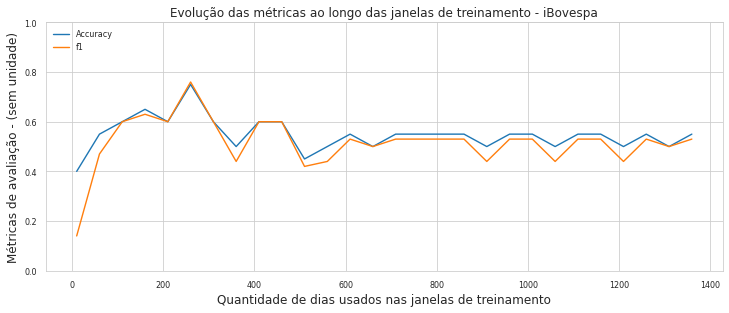

In [49]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

labels = df_metrics.index.tolist()
plt_accuracy_score = round(df_metrics['accuracy_score'], 2)
plt_f1_score = round(df_metrics['f1_score'],2)

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

rects1 = ax.plot(labels, plt_accuracy_score, label='Accuracy')
rects2 = ax.plot(labels, plt_f1_score, label='f1')

fig.tight_layout()

ax.set_ylim(0, 1)
# ax.set_xlim(-5, 5)
ax.set_title(f"Evolução das métricas ao longo das janelas de treinamento - {ticker}", fontsize=12)
ax.set_ylabel(f"Métricas de avaliação - (sem unidade)", fontsize=fontsize)
ax.set_xlabel(f"Quantidade de dias usados nas janelas de treinamento", fontsize=fontsize)
ax.legend(loc='upper left', frameon=False);

plt.show();

In [51]:
ntotal = df_ticker.shape[0]
ntest = 20
lst_janelas = np.arange(200, 400, 10)

metrics = {}

for janela in lst_janelas:
    resultado = {}
    for cont in np.arange(ntest):
        X_train = df_ticker[-janela-ntest+cont:-ntest+cont]
        X_test = df_ticker[-ntest+cont:ntotal-ntest+1+cont]

        X_train["rt"] = (np.log(X_train["Close"]) - np.log(X_train["Close"].shift(periods=1)))*100
        X_test["rt"] = (np.log(X_test["Close"]) - np.log(X_test["Close"].shift(periods=1)))*100
        df_ticker["rt"] = (np.log(df_ticker["Close"]) - np.log(df_ticker["Close"].shift(periods=1)))*100
        X_train = X_train[["Close", "rt"]][1:]

        model = pm.auto_arima(X_train['rt'], erro_action='ignore', trace=False, suppress_warnings=True, maxinter=5, stepwise=False, seasonal=False)

        test_pred, confint = model.predict(n_periods=1, return_conf_int=True)
        resultado[X_test.index[-1]] = {"y_pred": test_pred[0]}
    
    resultado = pd.DataFrame.from_dict(resultado, orient='index')
    resultado = pd.concat([resultado, df_ticker[-20:]["rt"]], axis=1)

    for column in resultado.columns[:2]:
        resultado[column+"_bin"] = np.where(resultado[column]>0, 1, 0)

    metrics[janela] = {
        'accuracy_score': accuracy_score(resultado["y_pred_bin"], resultado["rt_bin"]),
        'precision_score': precision_score(resultado["y_pred_bin"], resultado["rt_bin"]),
        'recall': recall_score(resultado["y_pred_bin"], resultado["rt_bin"]),
        'f1_score': f1_score(resultado["y_pred_bin"], resultado["rt_bin"])}

    print(janela, len(X_train), len(X_test), accuracy_score(resultado["y_pred_bin"], resultado["rt_bin"]))

200 199 1 0.6
220 219 1 0.65
240 239 1 0.7
260 259 1 0.75
280 279 1 0.6
300 299 1 0.6
320 319 1 0.45
340 339 1 0.45
360 359 1 0.5
380 379 1 0.55


In [52]:
df_metrics = pd.DataFrame.from_dict(metrics, orient='index')
df_metrics.sort_values(by="f1_score", ascending=False)

,accuracy_score,precision_score,recall,f1_score
260,0.75,0.8,0.727273,0.761905
240,0.70,0.8,0.666667,0.727273
300,0.60,0.7,0.583333,0.636364
220,0.65,0.6,0.666667,0.631579
200,0.60,0.6,0.600000,0.600000
280,0.60,0.6,0.600000,0.600000
380,0.55,0.5,0.555556,0.526316
360,0.50,0.4,0.500000,0.444444
320,0.45,0.4,0.444444,0.421053
340,0.45,0.4,0.444444,0.421053


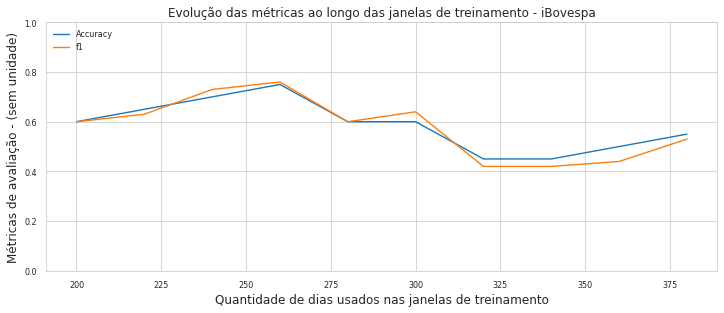

In [53]:
fig = plt.figure(figsize=(10, 4))
ax = fig.add_subplot(111)

labels = df_metrics.index.tolist()
plt_accuracy_score = round(df_metrics['accuracy_score'], 2)
plt_f1_score = round(df_metrics['f1_score'],2)

x = np.arange(len(labels))  # the label locations
width = 0.4  # the width of the bars

rects1 = ax.plot(labels, plt_accuracy_score, label='Accuracy')
rects2 = ax.plot(labels, plt_f1_score, label='f1')

fig.tight_layout()

ax.set_ylim(0, 1)
# ax.set_xlim(-5, 5)
ax.set_title(f"Evolução das métricas ao longo das janelas de treinamento - {ticker}", fontsize=12)
ax.set_ylabel(f"Métricas de avaliação - (sem unidade)", fontsize=fontsize)
ax.set_xlabel(f"Quantidade de dias usados nas janelas de treinamento", fontsize=fontsize)
ax.legend(loc='upper left', frameon=False);

plt.show();